In [1]:
pip install swig


In [2]:
pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (box2d-py)


In [4]:
!pip install gymnasium[box2d] pygame


  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached swig-4.3.1-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.3.1-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.9 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (box2d-py)


In [6]:
!apt-get install swig build-essential python3-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (535 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126333 files and directories currently installed.)
Preparing to unpack .../s

In [7]:
!pip install box2d-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp311-cp311-linux_x86_64.whl size=2351176 sha256=dd8effa0220e258c51eb8ee1879f2e410f30dab54bff673b6611821a8cb90f48
  Stored in directory: /root/.cache/pip/wheels/3f/95/02/4cb5adc9f6dcaeb9639c2271f630a66ab4440102414804c45c
Successfully built box2d-py


In [8]:
!pip install --no-binary :all: box2d-py

In [ ]:

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:


class RunningNorm:
    def __init__(self, epsilon=1e-5):
        self.mean = None
        self.std = None
        self.epsilon = epsilon
        self.count = 0

    def update(self, x):
        x = np.array(x)
        batch_mean = np.mean(x, axis=0)
        batch_std = np.std(x, axis=0)

        if self.mean is None:
            self.mean = batch_mean
            self.std = batch_std + self.epsilon
        else:
            old_count = self.count
            self.count += 1
            self.mean += (batch_mean - self.mean) / self.count
            self.std += (batch_std - self.std) / self.count
            self.std = np.maximum(self.std, self.epsilon)

    def normalize(self, x):
        if self.mean is None or self.std is None:
            return x
        return (x - self.mean) / self.std

In [ ]:



class A2CNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_actions):
        super(A2CNetwork, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.policy = nn.Linear(hidden_dim, n_actions)
        self.value = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy(x), self.value(x)

In [ ]:


def run_acrobot_training():
    env = gym.make('Acrobot-v1')
    input_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    model = A2CNetwork(input_dim, 128, n_actions)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    normalizer = RunningNorm()

    all_rewards = []
    avg_rewards = deque(maxlen=100)
    solved_counter = 0

    for ep in range(300):
        state, _ = env.reset(seed=SEED + ep)
        done = False
        ep_reward = 0
        step_count = 0

        states, actions, rewards, next_states, dones = [], [], [], [], []
        values = []

        while not done:
            norm_state = normalizer.normalize(state)
            state_tensor = torch.FloatTensor(norm_state).unsqueeze(0)
            logits, value = model(state_tensor)
            probs = torch.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample().item()

            next_state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            reward = 1.0
            ep_reward += reward

            normalizer.update([next_state])
            states.append(norm_state)
            actions.append(action)
            rewards.append(reward)
            dones.append(float(done))
            next_states.append(normalizer.normalize(next_state))
            values.append(value.item())

            state = next_state
            step_count += 1

            if done or step_count >= 500:
                with torch.no_grad():
                    next_tensor = torch.FloatTensor(normalizer.normalize(state)).unsqueeze(0)
                    _, next_value = model(next_tensor)
                    next_value = next_value.item()
                break

        values.append(next_value)
        returns = []
        gae = 0
        gamma = 0.99
        lam = 0.95
        for i in reversed(range(len(rewards))):
            delta = rewards[i] + gamma * values[i+1] * (1 - dones[i]) - values[i]
            gae = delta + gamma * lam * (1 - dones[i]) * gae
            returns.insert(0, gae + values[i])

        log_probs = []
        entropy_term = 0
        states_tensor = torch.FloatTensor(np.array(states))
        actions_tensor = torch.LongTensor(actions)
        returns_tensor = torch.FloatTensor(returns)
        values_tensor = torch.FloatTensor(values[:-1])

        logits, _ = model(states_tensor)
        logp_all = torch.log_softmax(logits, dim=-1)
        probs = torch.softmax(logits, dim=-1)
        log_probs = logp_all.gather(1, actions_tensor.unsqueeze(1)).squeeze()
        entropy = -(logp_all * probs).sum(dim=-1).mean()

        advantages = returns_tensor - values_tensor
        actor_loss = -(log_probs * advantages.detach()).mean()
        critic_loss = 0.5 * advantages.pow(2).mean()
        loss = actor_loss + critic_loss - 0.01 * entropy

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        all_rewards.append(ep_reward)
        avg_rewards.append(ep_reward)

        if ep % 10 == 0 or ep == 299:
            print(f"[Ep {ep+1}] Reward: {ep_reward}, Avg100: {np.mean(avg_rewards):.2f}")

    env.close()
    return all_rewards

rewards = run_acrobot_training()

[Ep 1] Reward: 500.0, Avg100: 500.00
[Ep 11] Reward: 500.0, Avg100: 500.00
[Ep 21] Reward: 341.0, Avg100: 466.24
[Ep 31] Reward: 500.0, Avg100: 466.90
[Ep 41] Reward: 500.0, Avg100: 474.98
[Ep 51] Reward: 500.0, Avg100: 479.88
[Ep 61] Reward: 500.0, Avg100: 483.18
[Ep 71] Reward: 500.0, Avg100: 485.55
[Ep 81] Reward: 500.0, Avg100: 487.33
[Ep 91] Reward: 500.0, Avg100: 488.73
[Ep 101] Reward: 500.0, Avg100: 489.74
[Ep 111] Reward: 500.0, Avg100: 489.74
[Ep 121] Reward: 454.0, Avg100: 496.37
[Ep 131] Reward: 470.0, Avg100: 484.78
[Ep 141] Reward: 163.0, Avg100: 463.03
[Ep 151] Reward: 158.0, Avg100: 440.49
[Ep 161] Reward: 500.0, Avg100: 421.29
[Ep 171] Reward: 500.0, Avg100: 416.40
[Ep 181] Reward: 500.0, Avg100: 402.48
[Ep 191] Reward: 500.0, Avg100: 400.48
[Ep 201] Reward: 500.0, Avg100: 398.07
[Ep 211] Reward: 500.0, Avg100: 395.71
[Ep 221] Reward: 395.0, Avg100: 389.05
[Ep 231] Reward: 500.0, Avg100: 398.50
[Ep 241] Reward: 500.0, Avg100: 404.59
[Ep 251] Reward: 294.0, Avg100: 407.

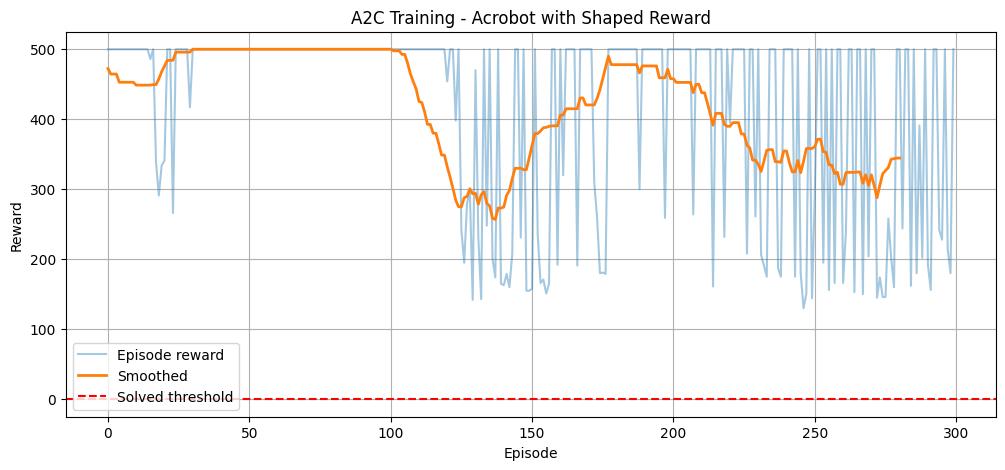

In [12]:


import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(rewards, label="Episode reward", alpha=0.4)
plt.plot(np.convolve(rewards, np.ones(20)/20, mode='valid'), label="Smoothed", linewidth=2)
plt.axhline(0, linestyle='--', color='red', label='Solved threshold')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.title("A2C Training - Acrobot with Shaped Reward")
plt.grid(True)
plt.show()


In [16]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque


In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
class RunningNorm:
    def __init__(self, shape, epsilon=1e-5):
        self.mean = np.zeros(shape)
        self.var = np.ones(shape)
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]

        delta = batch_mean - self.mean
        total = self.count + batch_count
        new_mean = self.mean + delta * batch_count / total
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + (delta ** 2) * self.count * batch_count / total
        new_var = M2 / total

        self.mean = new_mean
        self.var = new_var
        self.count = total

    def normalize(self, x):
        return (x - self.mean) / (np.sqrt(self.var) + 1e-8)

In [ ]:
class A2CNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.actor_mean = nn.Linear(hidden_dim, output_dim)
        self.actor_logstd = nn.Parameter(torch.zeros(output_dim))
        self.critic = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.shared(x)
        mean = self.actor_mean(x)
        std = torch.exp(self.actor_logstd)
        value = self.critic(x)
        return mean, std, value


In [ ]:
def compute_gae(rewards, values, next_value, dones, gamma=0.99, lam=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t+1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        returns.insert(0, gae + values[t])
    return returns


In [ ]:
def train_bipedalwalker(episodes=3000, hidden_dim=256, gamma=0.99, lr=3e-4):
    env = gym.make("BipedalWalker-v3")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    model = A2CNet(obs_dim, hidden_dim, act_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    norm = RunningNorm(obs_dim)

    train_rewards = []
    avg_rewards = deque(maxlen=100)

    for ep in range(episodes):
        state, _ = env.reset(seed=SEED + ep)
        done = False
        total_reward = 0

        log_probs, values, rewards, entropies, dones = [], [], [], [], []
        states = []

        while not done:
            norm.update(np.array([state]))
            s = norm.normalize(state)
            s_tensor = torch.FloatTensor(s).unsqueeze(0)

            mean, std, value = model(s_tensor)
            dist = torch.distributions.Normal(mean, std)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(axis=-1)
            entropy = dist.entropy().sum(axis=-1)

            next_state, reward, terminated, truncated, _ = env.step(action.squeeze().numpy())
            done = terminated or truncated

            states.append(s)
            log_probs.append(log_prob)
            values.append(value.item())
            rewards.append(reward)
            entropies.append(entropy)
            dones.append(float(done))

            total_reward += reward
            state = next_state

        with torch.no_grad():
            s = norm.normalize(state)
            s_tensor = torch.FloatTensor(s).unsqueeze(0)
            _, _, next_value = model(s_tensor)
            next_value = next_value.item()

        returns = compute_gae(rewards, values, next_value, dones)
        values = torch.FloatTensor(values)
        returns = torch.FloatTensor(returns)
        advantages = returns - values

        log_probs = torch.stack(log_probs)
        entropies = torch.stack(entropies)

        actor_loss = -(log_probs * advantages.detach()).mean()
        critic_loss = 0.5 * (returns - values).pow(2).mean()
        entropy_bonus = -0.01 * entropies.mean()

        loss = actor_loss + critic_loss + entropy_bonus

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        train_rewards.append(total_reward)
        avg_rewards.append(total_reward)

        if ep % 50 == 0 or ep == 0:
            print(f"[Ep {ep}] Reward: {total_reward:.2f}, Avg100: {np.mean(avg_rewards):.2f}")

    env.close()
    return model, norm, train_rewards

In [18]:
def evaluate(model, norm, episodes=10):
    env = gym.make("BipedalWalker-v3")
    rewards = []
    for ep in range(episodes):
        state, _ = env.reset(seed=SEED + 1000 + ep)
        done = False
        total_reward = 0
        while not done:
            s = norm.normalize(state)
            s_tensor = torch.FloatTensor(s).unsqueeze(0)
            with torch.no_grad():
                mean, _, _ = model(s_tensor)
            action = mean.squeeze().numpy()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
        print(f"[Eval] Ep {ep+1} Reward: {total_reward:.2f}")
    env.close()
    return rewards

In [ ]:
def plot_rewards(train_rewards, eval_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(train_rewards, alpha=0.3, label="Train Reward")
    smooth = np.convolve(train_rewards, np.ones(50)/50, mode='valid')
    plt.plot(range(len(smooth)), smooth, label="Smoothed")
    plt.axhline(300, color='green', linestyle='--', label="Solved Threshold")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.title("A2C - BipedalWalker-v3")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(eval_rewards)), eval_rewards)
    plt.axhline(300, color='green', linestyle='--', label="Solved Threshold")
    plt.title("Greedy Evaluation")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()


[Ep 0] Reward: -105.30, Avg100: -105.30
[Ep 50] Reward: -119.34, Avg100: -112.73
[Ep 100] Reward: -116.00, Avg100: -118.05
[Ep 150] Reward: -111.48, Avg100: -119.71
[Ep 200] Reward: -126.39, Avg100: -124.03
[Ep 250] Reward: -122.26, Avg100: -128.61
[Ep 300] Reward: -100.01, Avg100: -118.32
[Ep 350] Reward: -117.42, Avg100: -111.10
[Ep 400] Reward: -118.98, Avg100: -108.51
[Ep 450] Reward: -108.07, Avg100: -105.82
[Ep 500] Reward: -105.25, Avg100: -108.61
[Ep 550] Reward: -116.76, Avg100: -116.07
[Ep 600] Reward: -100.23, Avg100: -116.90
[Ep 650] Reward: -114.91, Avg100: -115.38
[Ep 700] Reward: -237.18, Avg100: -126.46
[Ep 750] Reward: -106.92, Avg100: -145.61
[Ep 800] Reward: -126.09, Avg100: -143.45
[Ep 850] Reward: -114.32, Avg100: -129.72
[Ep 900] Reward: -123.98, Avg100: -123.84
[Ep 950] Reward: -207.91, Avg100: -125.01
[Ep 1000] Reward: -122.66, Avg100: -130.15
[Ep 1050] Reward: -125.55, Avg100: -124.49
[Ep 1100] Reward: -133.55, Avg100: -121.20
[Ep 1150] Reward: -114.08, Avg100:

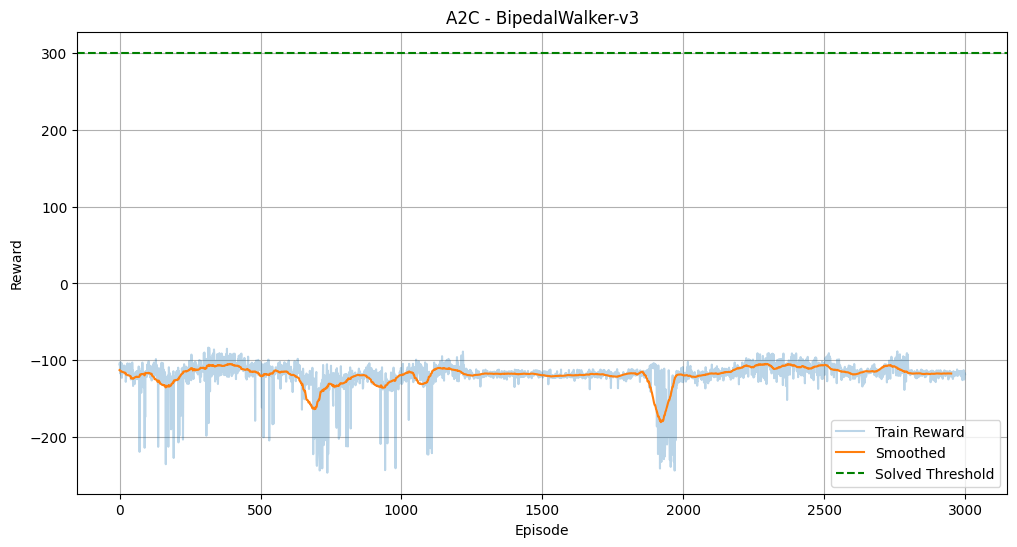

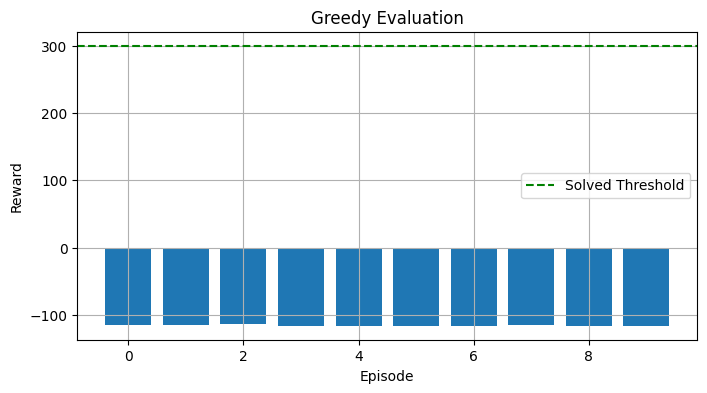

In [15]:
if __name__ == "__main__":
    model, norm, rewards = train_bipedalwalker()
    eval_rewards = evaluate(model, norm)
    plot_rewards(rewards, eval_rewards)

In [17]:
torch.save(model.state_dict(), 'bipedal_weights.pth')